## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import datetime as dt

In [46]:
%pip install xlrd scipy matplotlib seaborn scikit-learn dmba

   ---------------------------------------- 0.0/11.8 MB ? eta -:--:--
   ---------- ----------------------------- 3.1/11.8 MB 25.3 MB/s eta 0:00:01
   ------------------------------ --------- 8.9/11.8 MB 23.0 MB/s eta 0:00:01
   ---------------------------------------- 11.8/11.8 MB 22.0 MB/s eta 0:00:00

   ---------------------------------------- 0/2 [graphviz]
   ---------------------------------------- 0/2 [graphviz]
   ---------------------------------------- 0/2 [graphviz]
   ---------------------------------------- 0/2 [graphviz]
   -------------------- ------------------- 1/2 [dmba]
   -------------------- ------------------- 1/2 [dmba]
   -------------------- ------------------- 1/2 [dmba]
   ---------------------------------------- 2/2 [dmba]

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## Loading Dataset

In [ ]:
import os

def get_dataset_file_path(file_name):
    # Get current working directory
    cwd = os.getcwd()

    # Construct relative path to the dataset
    relative_path = os.path.join(cwd, "..", "datasets", file_name)

    # Convert to absolute path
    absolute_path = os.path.abspath(relative_path)

    return absolute_path

# Example usage
file_name = "Book3.csv"
get_dataset_file_path(file_name)

'c:\\Users\\visha\\OneDrive\\Documents\\ML-Project\\Electricity_Load_n_Price_Forecasting\\datasets\\Book3.csv'

In [18]:
file_name = "Book3.csv"
file_path = get_dataset_file_path(file_name)
data = pd.read_csv(file_path)
display(data)

,Date,Hour,DryBulb,DewPnt,SYSLoad,NumDate
0,2004-01-01 00:00:00.0,1,37,25,12230,732000.0
1,2004-01-01 00:00:00.0,2,37,25,11534,732000.0
2,2004-01-01 00:00:00.0,3,39,24,11038,732000.0
3,2004-01-01 00:00:00.0,4,38,22,10777,732000.0
4,2004-01-01 00:00:00.0,5,37,20,10764,732000.0
...,...,...,...,...,...,...
52603,2009-12-31 00:00:00.0,20,28,25,17419,734000.0
52604,2009-12-31 00:00:00.0,21,27,25,16514,734000.0
52605,2009-12-31 00:00:00.0,22,27,25,15633,734000.0
52606,2009-12-31 00:00:00.0,23,27,24,14739,734000.0


In [21]:
# Holidays data
file_name = "Holidays.xls"
file_path = get_dataset_file_path(file_name)
hdata = pd.read_excel(file_path)
display(hdata.head())

,Date,Holiday
0,2004-01-01,New Year's Day
1,2004-01-19,Martin Luther King Day
2,2004-02-16,President's Day
3,2004-05-31,Memorial Day
4,2004-07-05,Independence Day


## Data Preprocessing

In [22]:
holidays=hdata.Date
holidays.head()

0   2004-01-01
1   2004-01-19
2   2004-02-16
3   2004-05-31
4   2004-07-05
Name: Date, dtype: datetime64[ns]

In [23]:

#Convert dates to datetime data type
data['Date']=pd.to_datetime(data['Date'])
data.dtypes


Date       datetime64[ns]
Hour                int64
DryBulb             int64
DewPnt              int64
SYSLoad             int64
NumDate           float64
dtype: object

In [24]:
#get the day of the week for each date in the data
dayofweek=data.Date.dt.weekday
dayofweek.head()

0    3
1    3
2    3
3    3
4    3
Name: Date, dtype: int32

In [25]:
isworkday = np.in1d(dayofweek,[0,1,2,3,4]) & ~np.in1d(data['Date'],holidays)
isworkday[22]

C:\Users\visha\AppData\Local\Temp\ipykernel_8420\1689000366.py:1: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  isworkday = np.in1d(dayofweek,[0,1,2,3,4]) & ~np.in1d(data['Date'],holidays)


np.False_

In [26]:
prevdaysamehour=np.hstack(((np.ones(24)*-1),(data['SYSLoad'][0:-24])))
prevdaysamehour[0]

np.float64(-1.0)

In [27]:
prevweeksamehour=np.hstack(((np.ones(168)*-1),(data['SYSLoad'][0:-168])))
prevweeksamehour.shape

(52608,)

In [31]:
import scipy
import scipy.signal
#By using the lfilter method get the previous 24 hour averrage temperature
prev24houravg = scipy.signal.lfilter(np.ones(24) / 24, 1, data['SYSLoad'])
prev24houravg.shape

(52608,)

In [32]:
#Put all the input data together into a single matrix
X = np.vstack((data['DryBulb'],data['DewPnt'],data['Hour'],dayofweek))
X.shape
display(pd.DataFrame(X.T).head(5))

,0,1,2,3
0,37,25,1,3
1,37,25,2,3
2,39,24,3,3
3,38,22,4,3
4,37,20,5,3


In [33]:
#Put all the input data together into a single matrix
X = np.vstack((data['DryBulb'],data['DewPnt'],data['Hour'],dayofweek,isworkday,prevweeksamehour,prevdaysamehour,prev24houravg))
X.shape
display(pd.DataFrame(X.T).head(5))

,0,1,2,3,4,5,6,7
0,37.0,25.0,1.0,3.0,0.0,-1.0,-1.0,509.583333
1,37.0,25.0,2.0,3.0,0.0,-1.0,-1.0,990.166667
2,39.0,24.0,3.0,3.0,0.0,-1.0,-1.0,1450.083333
3,38.0,22.0,4.0,3.0,0.0,-1.0,-1.0,1899.125000
4,37.0,20.0,5.0,3.0,0.0,-1.0,-1.0,2347.625000


In [34]:
X=np.transpose(X)
X.shape

(52608, 8)

In [35]:
numcols=X.shape[1]


In [36]:
#Take out the first 168 indexes because they have null values
X=X[168:,:]
data=data[168:]
print(X.shape)
print(data.shape)

(52440, 8)
(52440, 6)


## Training and Testing Split

In [37]:
#Find the training index that will be used to split the data into train and test
trainInd = data.Date < dt.datetime(2008, 1, 1)
trainX = X[trainInd,:]
trainX.shape

(34896, 8)

In [38]:
#assign the training outputs
trainY=data.SYSLoad[trainInd]
trainY=trainY.to_numpy()
trainY = trainY.reshape((trainY.shape[0], 1))
trainY.shape

(34896, 1)

In [39]:
#split the range for the validation data
validX=X[34896:43680]
validX.shape
validX[-1]

array([ 8.0000000e+00, -5.0000000e+00,  2.4000000e+01,  2.0000000e+00,
        1.0000000e+00,  1.3253000e+04,  1.3827000e+04,  1.6115375e+04])

In [ ]:
validY = data.SYSLoad[34896:43680]
validY = validY.to_numpy()
validY = validY.reshape((validY.shape[0], 1))
validY[-1]

array([15438])

In [41]:
testInd = data.Date>= dt.datetime(2009, 1, 1)
testX=X[testInd,:]
print(testX)

[[ 7.00000000e+00 -6.00000000e+00  1.00000000e+00 ...  1.21240000e+04
   1.28040000e+04  1.61936250e+04]
 [ 6.00000000e+00 -7.00000000e+00  2.00000000e+00 ...  1.13450000e+04
   1.21980000e+04  1.62724583e+04]
 [ 6.00000000e+00 -8.00000000e+00  3.00000000e+00 ...  1.08240000e+04
   1.19230000e+04  1.63455417e+04]
 ...
 [ 2.70000000e+01  2.50000000e+01  2.20000000e+01 ...  1.54490000e+04
   1.73440000e+04  1.58159167e+04]
 [ 2.70000000e+01  2.40000000e+01  2.30000000e+01 ...  1.47590000e+04
   1.59130000e+04  1.57670000e+04]
 [ 2.70000000e+01  2.40000000e+01  2.40000000e+01 ...  1.38030000e+04
   1.44660000e+04  1.57456250e+04]]


In [42]:
testY=data.SYSLoad[testInd]
testY=testY.to_numpy()
testY = testY.reshape((testY.shape[0], 1))

## Model Training

In [ ]:

from sklearn.svm import SVR
from dmba import regressionSummary
from sklearn.metrics import r2_score

# Train the SVM model
svm = SVR(kernel='rbf')
svm.fit(trainX, trainY.ravel())

# Predict and evaluate on the validation set
predY_svm = svm.predict(validX)

# Evaluate the model
regressionSummary(validY, predY_svm)
accuracy_svm = r2_score(validY, predY_svm)
print(f"SVM Validation R^2 Score: {accuracy_svm:.4f}")


Regression statistics

                      Mean Error (ME) : -118.9072
       Root Mean Squared Error (RMSE) : 1665.8762
            Mean Absolute Error (MAE) : 1299.8923
          Mean Percentage Error (MPE) : -2.8961
Mean Absolute Percentage Error (MAPE) : 9.2438
SVM Validation R^2 Score: 0.6550


## Model Evaluation

In [56]:
# dbma Regression Summary Testing data
from dmba import regressionSummary
predY_svm = svm.predict(testX)
regressionSummary(testY, predY_svm)
print(f"SVM Test R^2 Score: {r2_score(testY, predY_svm):.4f}")


Regression statistics

                      Mean Error (ME) : -352.2007
       Root Mean Squared Error (RMSE) : 1645.9203
            Mean Absolute Error (MAE) : 1289.5173
          Mean Percentage Error (MPE) : -4.6705
Mean Absolute Percentage Error (MAPE) : 9.8037
SVM Test R^2 Score: 0.6520


In [51]:
# Storing Model inferences
import joblib
model_name = "svm.pkl"
model_file_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'inference', model_name))
joblib.dump(svm, model_file_path)
print(f"Model saved to {model_file_path}")

Model saved to c:\Users\visha\OneDrive\Documents\ML-Project\Electricity_Load_n_Price_Forecasting\inference\svm.pkl


## Actual vs Prediction Chart

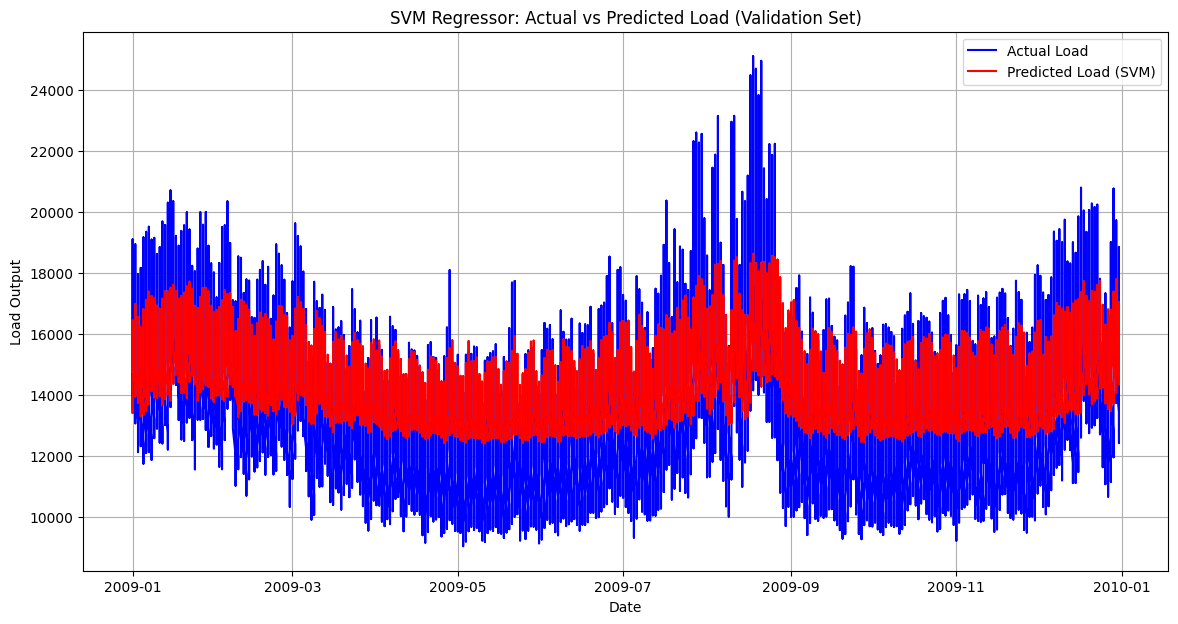

In [61]:
import matplotlib.pyplot as plt

# Extract dates for the validation set
validation_dates = data.Date[testInd]

# Plot actual vs predicted values for the validation set
plt.figure(figsize=(14, 7))
plt.plot(validation_dates, testY, label='Actual Load', color='blue')
plt.plot(validation_dates, predY_svm, label='Predicted Load (SVM)', color='red', linestyle='-')

plt.xlabel('Date')
plt.ylabel('Load Output')
plt.title('SVM Regressor: Actual vs Predicted Load (Validation Set)')
plt.legend()
plt.grid(True)
plt.show()

## Conclusion

1. Slight Underestimation: The Mean Error (ME) of -235.39 suggests the model tends to slightly underestimate the actual values.

2. Moderate Prediction Accuracy: With a Root Mean Squared Error (RMSE) of 1655.94, the model shows moderate variability in prediction errors, which may impact reliability for high-stakes forecasting.

3. Reasonable Precision: The Mean Absolute Error (MAE) of 1294.71 indicates that, on average, predictions deviate from actual values by around 1,295 units—acceptable depending on the scale of your target variable.

4. Acceptable Percentage Error: A MAPE of 9.52% implies the model’s predictions are off by less than 10% on average